In [1]:
# SETUP yours
user_libs = "C:/Users/User/AppData/Local/R/cache/R/renv/library/functional-data-regression-mip-e3349204/R-4.3/x86_64-w64-mingw32"
.libPaths(c(user_libs,.libPaths()))



In [2]:
# run_simulation.R
# This script contains the function to run the simulation and returns all relevant outputs.

library(refund)
library(MASS)
library(fda)
library(here)

# Source the generic simulator script
source(here("src", "R", "generic_simulator", "simulate_main.R"))
source(here("src", "R", "generic_simulator", "utils","loader_utilities.R"))


# Define the function to run the simulation
run_simulation <- function(params) {
  # Ensure that the seed is set for reproducibility
  
  # Call the main analysis function with the parameters
  result <- do.call(generate_data, params[c("predictors", "observations", "measurements", "basis_functions", "intercept", "norder", "mu_funcs", "beta_funcs","time_domains", "cov_funcs", "seed","noise_snr","simulation_type")] )
    
  # Return the output list
  return(result)
}



simulation_name = "paper"
simulation_settings_file = "default"
# Required inputs before running the simulation!!!
inputs  <- load_simulation_settings(simulation_name, simulation_settings_file)
inputs$measurements <- 50
inputs$observations <- 300
inputs$basis_functions <- 6
inputs$seed <- 0
time_domains_eval <- lapply(inputs$time_domains, function(domain) {
           seq(from = domain[[1]], to = domain[[2]], length.out = inputs$measurements)
       })
inputs$time_domains <- time_domains_eval
inputs$noise_snr <- c(100,100)
outputs <- run_simulation(inputs);


## ADAPTATION TO GETHEIS DATA
X = outputs$X
Y = outputs$Y
obseravation = dim(X)[1]    
predictors = dim(X)[2]
measurements = dim(X)[3]

fobs <- list()
for (j in 1:predictors) {
  fobs[[j]] <- matrix(0, obseravation, measurements)
  for (i in 1:obseravation) {
    fobs[[j]][i,] <- X[i,j,]
  }
}

tps <- list()
# for any time_domain, create a vector of time points from 1:measurements
tps <- inputs$time_domains



Warning message:
"il pacchetto 'refund' è stato creato con R versione 4.3.2"
Warning message:
"il pacchetto 'fda' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: splines

Caricamento del pacchetto richiesto: fds

Warning message:
"il pacchetto 'fds' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: rainbow

Warning message:
"il pacchetto 'rainbow' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: pcaPP

Warning message:
"il pacchetto 'pcaPP' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: RCurl

Warning message:
"il pacchetto 'RCurl' è stato creato con R versione 4.3.2"
Caricamento del pacchetto richiesto: deSolve

Warning message:
"il pacchetto 'deSolve' è stato creato con R versione 4.3.2"

Caricamento pacchetto: 'fda'


Il seguente oggetto è mascherato da 'package:graphics':

    matplot


Warning message:
"il pacchetto 'here' è stato creato con R versione 4.3.2"
here() starts at C:/U

[1] 100 NaN NaN
[1] "predictors: 6"
[1] "observations: 300"
[1] "measurements: 50"
[1] "basis_functions: 6"
[1] "intercept: 0"
[1] 562.91977 123.90356  32.47708  85.60745 109.99000 120.29415
[1] 11.36916


In [3]:
require(splines)
require(grplasso)

to_matrix_form <-  function(predictor_coefficients, predictors, basis_functions) {
    # Create a matrix with 'basis_functions' elements per row
    # and the number of rows equal to the number of predictors from coeff_full
    coeff_matrix = matrix(0, nrow = predictors, ncol = basis_functions)

    for (i in 1:(predictors * basis_functions)) {
        # Calculate the row index as the ceiling of the division of 'i' by 'basis_functions'
        row_index = (i - 1) %/% basis_functions + 1
        # Calculate the column index as 'i' modulo 'basis_functions'; if modulo is 0, it means it's the last measurement
        col_index = ifelse(i %% basis_functions == 0, basis_functions, i %% basis_functions)
        # Assign the value of the coefficient to the matrix
        coeff_matrix[row_index, col_index] = predictor_coefficients[i]
}

  return(coeff_matrix)
}



grplFlinear <- function(Y, X, Tps, lambda, phi, dfs = 10,
adapt1 = NULL, adapt2 = NULL, ...){

	#### Observed functions x_{ij}(t) at possibly different support grids t
	## Y = nx1 vector of responses
	## X = list of matrices, each element corresponds to observations of one functional predictor.
	##		Thus, [[jj]] would provide the jj-th observed function with subjects as rows and the support grid as columns
	##		Note that each function (i.e. component of X) can have different support
	## Tps = list of vectors, each element is a suppport grid of the corresponding observed function.
	##		Thus, Tps[[jj]] would give the support grid of the jj-th observed function. This grid is
	##		assumed to be the same for all subjects ii, and equidistant
	## lambda = vector of penalty parameters
	## phi = penalty parameter for smoothing
	## dfs = dfs used for basis expansions of coefficient functions (can be a vector)


	nsub = length(Y) ## number of subjects
	nfunc = length(Tps) ## number of functions per subject



	#### We use bsplines as basis functions for the corrsponding beta functions
  if (length(dfs) == 1)
    dfs = rep(dfs, nfunc) ## vector of intended df of each spline basis
  if (length(dfs) != nfunc)
    stop("length of dfs does not match number of predictors")

	B <- Psi <- Omega <- K <- iR <- eK <- list()
	delt <- rep(NA, nfunc)


	for (jj in 1:nfunc){
		
    spj = diff(range(Tps[[jj]]))#/(dfs[jj]-2)
    bknj = c(min(Tps[[jj]]) - spj, max(Tps[[jj]]) + spj) ## boundary knots
		B[[jj]] = bs(Tps[[jj]], df=dfs[jj], Boundary.knots=bknj) ## basis spline set up
		delt[jj] = Tps[[jj]][2] - Tps[[jj]][1] ## differences in Tps

		Psi[[jj]] = delt[jj] * t(B[[jj]]) %*% B[[jj]] ## approximate norm of bsplines assuming dense design
    if (length(adapt1) == nfunc)
      Psi[[jj]] = adapt1[jj]*Psi[[jj]]

    dBj <- matrix(NA,nrow(B[[jj]]),ncol(B[[jj]]))
    for (k in 1:ncol(B[[jj]])) ## computation of second derivatives
      {
        iS <- interpSpline(Tps[[jj]],B[[jj]][,k])
        dBj[,k] <- predict(iS, Tps[[jj]], deriv = 2)$y
      }
    Omega[[jj]] = delt[jj] * t(dBj) %*% dBj ## approximate norm of 2nd deriv of bsplines assuming dense design
    if (length(adapt2) == nfunc)
      Omega[[jj]] = adapt2[jj]*Omega[[jj]]

		K[[jj]] = Psi[[jj]] + phi * Omega[[jj]] ## K matrix

    # Check eigenvalues
    eig_vals <- eigen(K[[jj]])$values
    if (any(eig_vals <= 0)) {
        cat("Matrix K[", jj, "] has non-positive eigenvalues.\n")
        # Diagonal loading for numerical stability
        K[[jj]] <- K[[jj]] + diag(abs(min(eig_vals)) + 1e-6, ncol(K[[jj]]))
    }


    eK[[jj]] <- eigen(K[[jj]])
    #iR[[jj]] <- t((1/sqrt(eK[[jj]]$values))*t(eK[[jj]]$vectors))
		iR[[jj]] = backsolve(chol(K[[jj]]), x = diag(ncol(K[[jj]])))  ## inverse of cholesky of K
	}


	## covariates for the linear model
	Z = 1
	for (jj in 1:nfunc)
    {
			tmp = delt[jj]*(X[[jj]]%*%B[[jj]])
			Z = cbind(Z, tmp%*%iR[[jj]])
		}


	## group lasso
	index = c(NA,rep(1:nfunc,dfs))
	grpl = grplasso(x = Z, y = Y, index = index, model = LinReg(), lambda = lambda,
  standardize = F, ...)


  ## output: intercept and fitted coefficient functions
  intercept = grpl$coef[1,]
  Coef <- list()
  index[1] = 0
  for (jj in 1:nfunc)
    {
      Coef[[jj]] <- B[[jj]]%*%iR[[jj]]%*%grpl$coef[index == jj,]
    }

  out = list("intercept" = intercept, "Coef" = Coef, "real_coef" = grpl$coef, "Z" = Z)
	return(out)
}


grplMFLM <- function(k, Y, X, Tps, lambda, phi, dfs = 10, ...)
  {
  # K-fold cross-validation function
    n <- length(Y)
    p <- length(X)
    os <- sample(n,n)
    
    cvError <- array(NA, c(k,length(phi),length(lambda)))
    nk <- floor(n/k)
    for (wk in 1:k)
      {
        cat("fold",wk,"\n")
        if (wk < k)
          inds <- os[(wk-1)*nk+(1:nk)]
        else
          inds <- os[-(1:((wk-1)*nk))]

        # training/test obs
        Xk <- X
        Xkt <- X
       	delt = rep(NA, p)
        for (jj in 1:p)
          {
            Xk[[jj]] <- X[[jj]][-inds,]
            Xkt[[jj]] <- X[[jj]][inds,]
        		delt[jj] = Tps[[jj]][2] - Tps[[jj]][1]
          }
        Yk <- Y[-inds]
        Ykt <- Y[inds]

       # phi walues
        for (wp in 1:length(phi))
          {
            # model fitting
            grplk <- grplFlinear(Y = Yk, X = Xk, Tps = Tps, lambda = lambda, 
            phi = phi[wp], dfs = dfs, ...)
            
            # test set prediction
            predk <- matrix(NA,length(inds),length(lambda))
            for (ll in 1:length(lambda))
              {
                predll <- rep(grplk$intercept[ll],nrow(predk))
                for (jj in 1:p)
                  {
                    predll <- predll + delt[jj]*Xkt[[jj]]%*%grplk$Coef[[jj]][,ll]
                  }
                # error
                cvError[wk,wp,ll] <- sum((Ykt - predll)^2)
              }
          }
      }
    return(cvError)
  }
  
  

Caricamento del pacchetto richiesto: grplasso

Warning message:
"il pacchetto 'grplasso' è stato creato con R versione 4.3.0"


In [4]:
print( outputs$B)

             [,1]      [,2]      [,3]      [,4]      [,5]     [,6]
[1,] 4.227235e-06 0.1111013 0.3333239 0.6299258 0.7814749 0.841467
[2,] 1.500439e-04 0.2323840 0.6976011 1.0681667 0.9830667 0.865998
[3,] 0.000000e+00 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
[4,] 1.500439e-04 0.2323840 0.6976011 1.0681667 0.9830667 0.865998
[5,] 0.000000e+00 0.0000000 0.0000000 0.0000000 0.0000000 0.000000
[6,] 0.000000e+00 0.0000000 0.0000000 0.0000000 0.0000000 0.000000


In [6]:
# fit using functional smooth group lasso
lambda <- 10^seq(5,-8,by=-1)
phi <- 10^seq(5, -5,,by=-1)


In [7]:
    # cross-validation
cvError <- grplMFLM(k = 5, Y = Y, X = fobs, Tps = tps, lambda = lambda , phi = phi, dfs = inputs$basis_functions)
cvError <- apply(cvError,c(2,3),sum)
best_phi <- wp <- which.min(apply(cvError,1,min))
best_lambda <- wl <- which.min(cvError[wp,])
print(phi[best_phi], lambda[best_lambda])
print(cvError[best_phi, best_lambda])


fold 1 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 31 
Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


Lambda: 1e-06  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[13]"


Lambda: 1e-07  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[14]"


Lambda: 1e-08  nr.var: 37 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[7]"


Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


Lambda: 1e-06  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[13]"


Lambda: 1e-07  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[14]"


Lambda: 1e-08  nr.var: 37 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[7]"


Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


: 

In [ ]:
print(phi[best_phi][1], lambda[best_lambda])


[1] 1


In [105]:
mat_full = grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda[best_lambda], phi = phi[best_phi[1]], dfs = inputs$basis_functions )

mat = grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda[best_lambda], phi = phi[best_phi[1]], dfs = inputs$basis_functions )$real_coef

intercept <- mat[1, 1]
mat_coeff <- mat[-1, ]
betas_ =to_matrix_form(mat_coeff,predictors = predictors, basis_functions = inputs$basis_functions)
print(betas_)

Lambda: 0.1  nr.var: 16 
Lambda: 0.1  nr.var: 16 
           [,1]        [,2]       [,3]        [,4]        [,5]
[1,] 0.96977119 -1.09381727  0.8901635  0.83285378 -2.49841279
[2,] 0.42309011  0.52948857 -2.1131620  1.34364110  0.14373193
[3,] 0.02788115  0.02243463 -0.0313756 -0.04228097 -0.03157118


In [4]:
# Convert the list of matrices into a matrix
matrix <- do.call(rbind, lapply(mat_full$Coef, t))
# Check the dimensions of the matrix
source(here("src","R", "generic_simulator", "config.R"))  
basis_objs <- outputs$basis_objs
result <- smooth_betas_generic(matrix, basis_functions, inputs$time_domains, basis_objs)
result$beta_matrix


ERROR: Error in lapply(mat_full$Coef, t): oggetto 'mat_full' non trovato


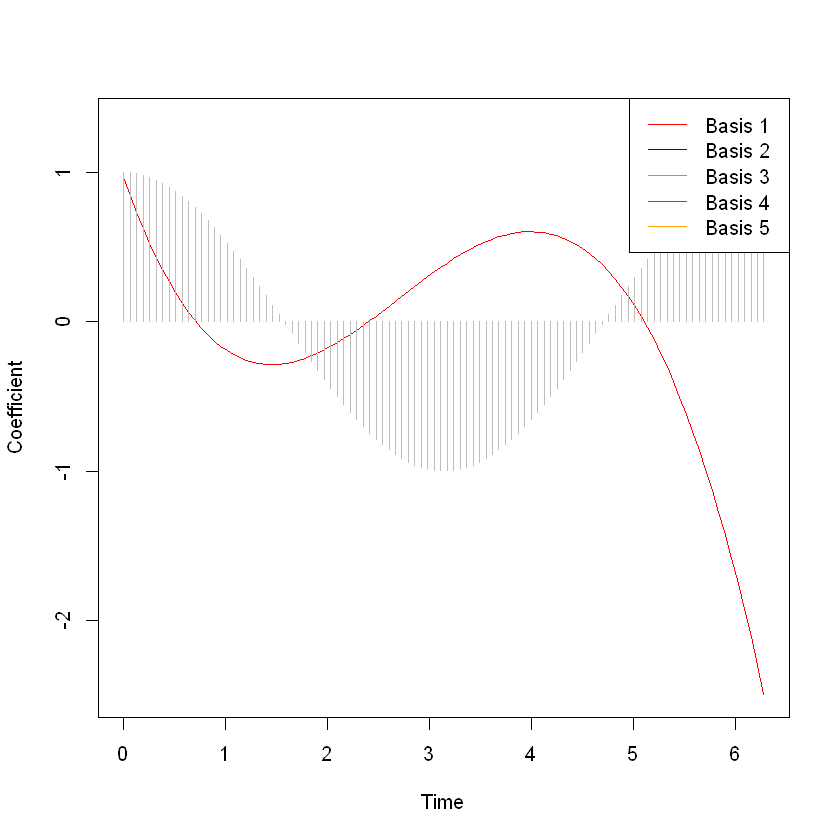

In [111]:
# Assuming mat_full$Coef[[1]] is a matrix with 5 columns
coef_matrix <- betas_
beta_points = outputs$basis_values

# Create a vector for the x-axis (time domain)
time_domain <- tps[[1]]

# Create a plot for each column
plot(time_domain,beta_points[1,,] %*% coef_matrix[1,]   , type='l', col='red', ylim=range(coef_matrix), xlab='Time', ylab='Coefficient')

lines(time_domain, beta_funcs[[1]](tps[[1]]), type="h",col="gray")

# Add a legend
legend("topright", legend=c("Basis 1", "Basis 2", "Basis 3", "Basis 4", "Basis 5"), col=c('red', 'blue', 'green', 'purple', 'orange'), lty=1)

In [83]:
# transpose mat_full$Coef
print(mat_full$Coef[[1]])


              [,1]
  [1,]  1.35796254
  [2,]  1.29790945
  [3,]  1.23773675
  [4,]  1.17748471
  [5,]  1.11719360
  [6,]  1.05690368
  [7,]  0.99665524
  [8,]  0.93648854
  [9,]  0.87644385
 [10,]  0.81656145
 [11,]  0.75688160
 [12,]  0.69744457
 [13,]  0.63829064
 [14,]  0.57946008
 [15,]  0.52099316
 [16,]  0.46293014
 [17,]  0.40531130
 [18,]  0.34817692
 [19,]  0.29156725
 [20,]  0.23552257
 [21,]  0.18008316
 [22,]  0.12528928
 [23,]  0.07118121
 [24,]  0.01779921
 [25,] -0.03481644
 [26,] -0.08662548
 [27,] -0.13758763
 [28,] -0.18766262
 [29,] -0.23681018
 [30,] -0.28499004
 [31,] -0.33216193
 [32,] -0.37828558
 [33,] -0.42332071
 [34,] -0.46722706
 [35,] -0.50995269
 [36,] -0.55139894
 [37,] -0.59145550
 [38,] -0.63001206
 [39,] -0.66695831
 [40,] -0.70218391
 [41,] -0.73557857
 [42,] -0.76703195
 [43,] -0.79643375
 [44,] -0.82367365
 [45,] -0.84864133
 [46,] -0.87122648
 [47,] -0.89131877
 [48,] -0.90880790
 [49,] -0.92358355
 [50,] -0.93553540
 [51,] -0.94455313
 [52,] -0.95

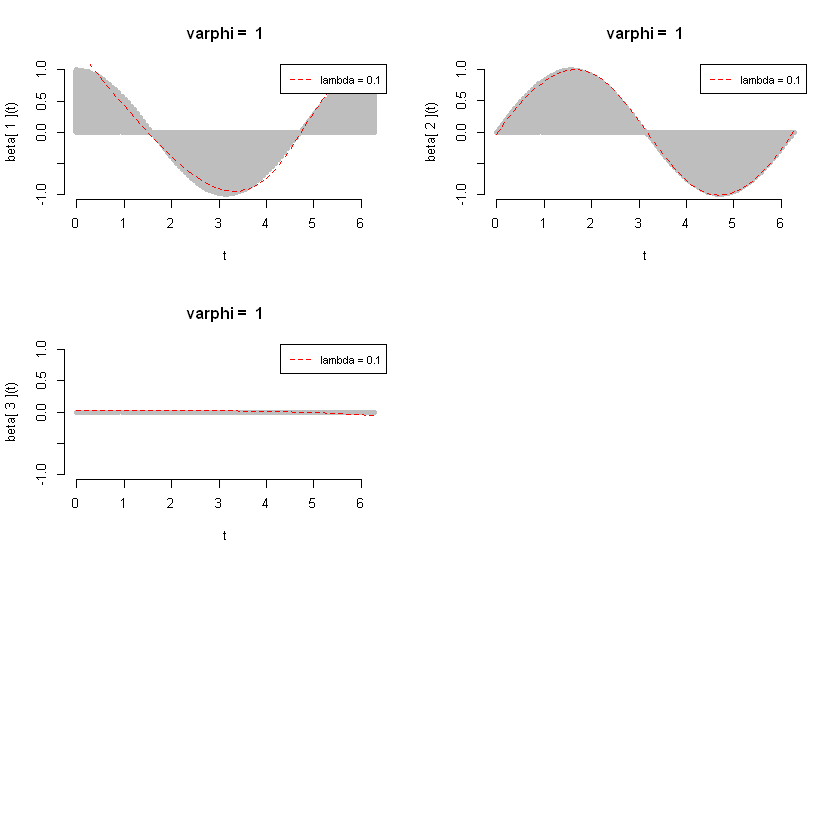

In [30]:


# plot this coefficients curves
colors <- rainbow(length(lambda))  # Generate a color palette with as many colors as there are lambda values

  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    y_values = beta_funcs[[j]](tps[[j]])
    plot(tps[[j]], y_values, type="h",col="gray",lwd=5,ylim=range(y_values),  xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")

    lines(tps[[j]], mat_full$Coef[[j]],lty=2, col=colors[1])
    legend("topright", legend=paste("lambda =", lambda[best_lambda]), col=colors, lty=2, cex=0.8)

    title(paste("varphi = ", phi[best_phi]))
  }


Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 
Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


Lambda: 1e-06  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[13]"


Lambda: 1e-07  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[14]"


Lambda: 1e-08  nr.var: 37 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[7]"


Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


Lambda: 1e-06  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[13]"


Lambda: 1e-07  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[14]"


Lambda: 1e-08  nr.var: 37 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 
Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


Lambda: 1e-06  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[13]"


Lambda: 1e-07  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[14]"


Lambda: 1e-08  nr.var: 37 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[7]"


Lambda: 0.1  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[8]"


Lambda: 0.01  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[9]"


Lambda: 0.001  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[10]"


Lambda: 1e-04  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[11]"


Lambda: 1e-05  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[12]"


Lambda: 1e-06  nr.var: 37 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[13]"


Lambda: 1e-07  nr.var: 37 
Lambda: 1e-08  nr.var: 37 
Setting update.every = length(lambda) + 1
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 19 
Lambda: 10  nr.var: 19 
Lambda: 1  nr.var: 37 
Lambda: 0.1  nr.var: 37 
Lambda: 0.01  nr.var: 37 
Lambda: 0.001  nr.var: 37 
Lambda: 1e-04  nr.var: 37 
Lambda: 1e-05  nr.var: 37 
Lambda: 1e-06  nr.var: 37 
Lambda: 1e-07  nr.var: 37 
Lambda: 1e-08  nr.var: 37 
[1] "phi: 1e+05 lambda: 1e+05"
     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    0    0    0    0
[2,]    0    0    0    0    0    0
[3,]    0    0    0    0    0    0
[4,]    0    0    0    0    0    0
[5,]    0    0    0    0    0    0
[6,]    0    0    0    0    0    0
[1] "phi: 1e+05 lambda: 10000"
     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    0    0    0    0
[2,]    0    0    0    0    0    0
[3,]    0    0    0    0    0    0
[4,]    0    0    0    0    0    0
[5,]    0    0    0    0    0    0
[6,]    0    0    0    0 

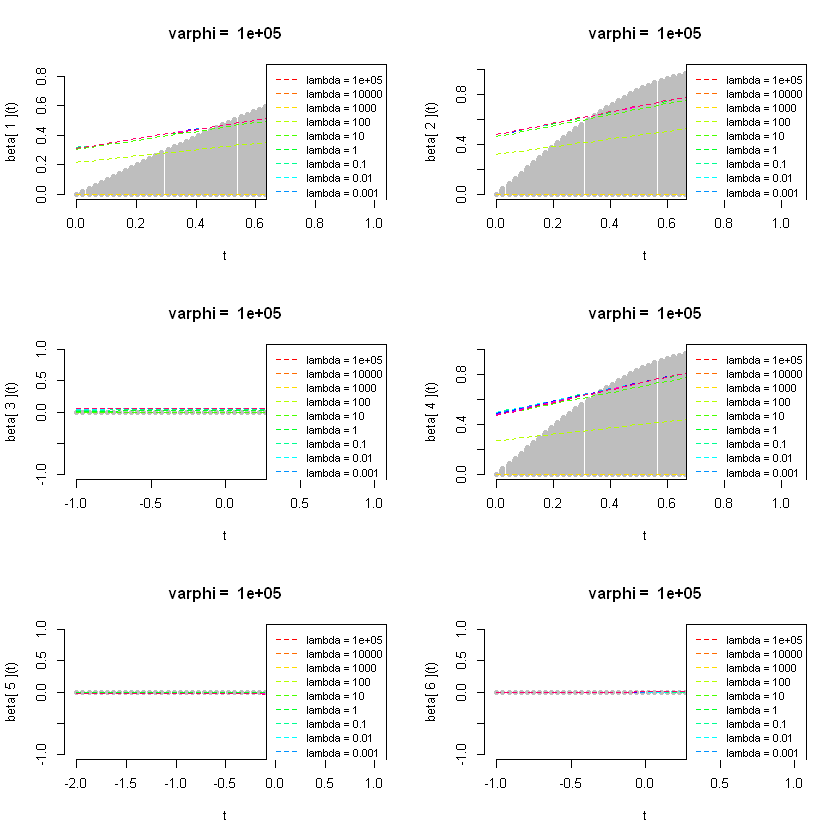

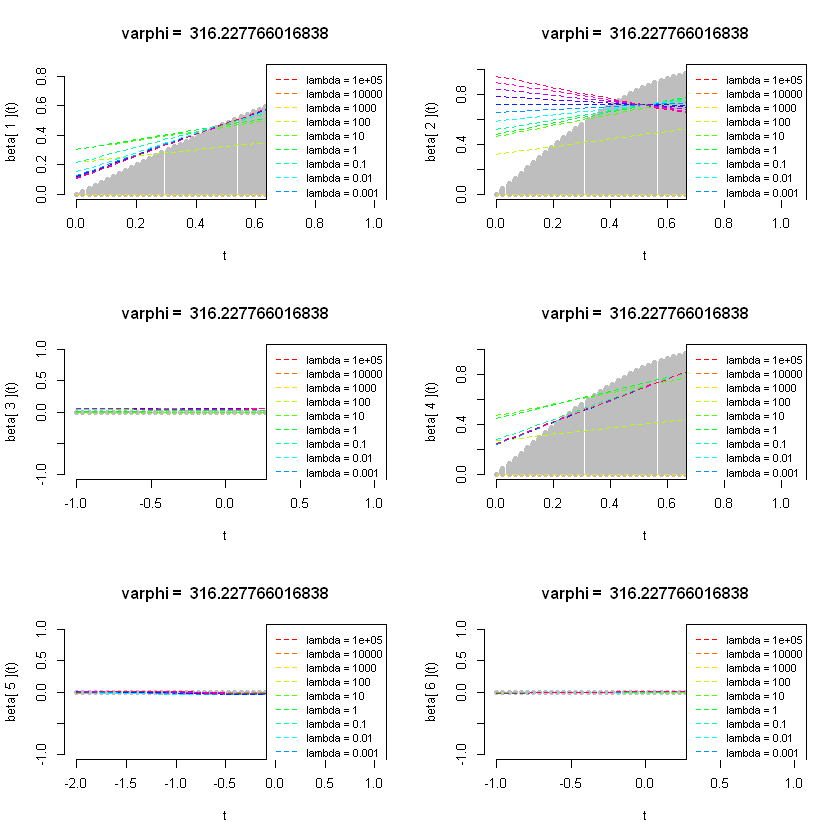

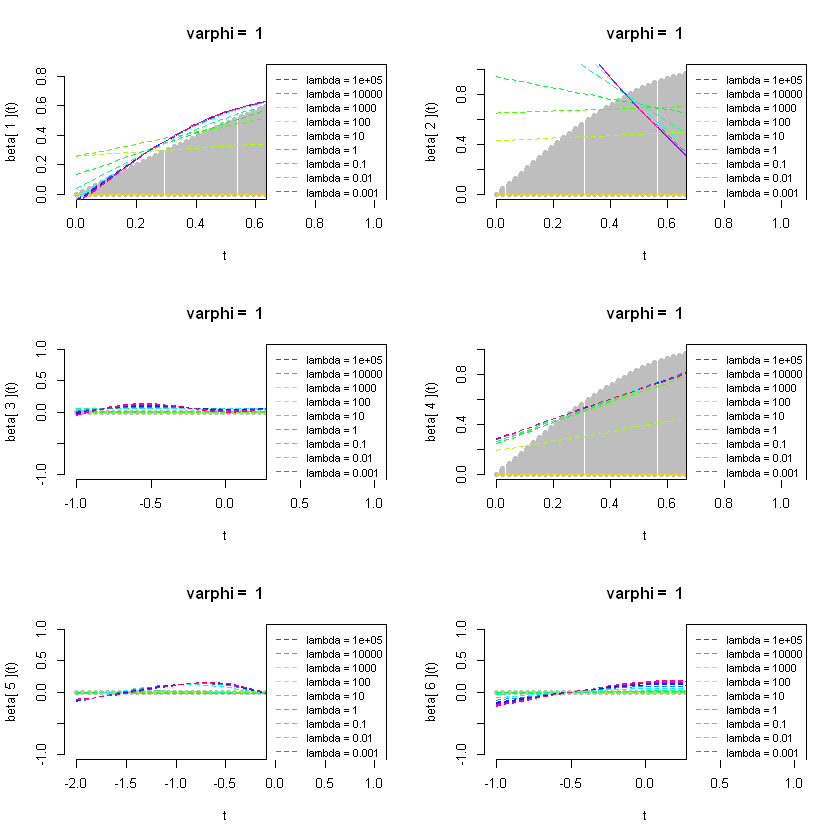

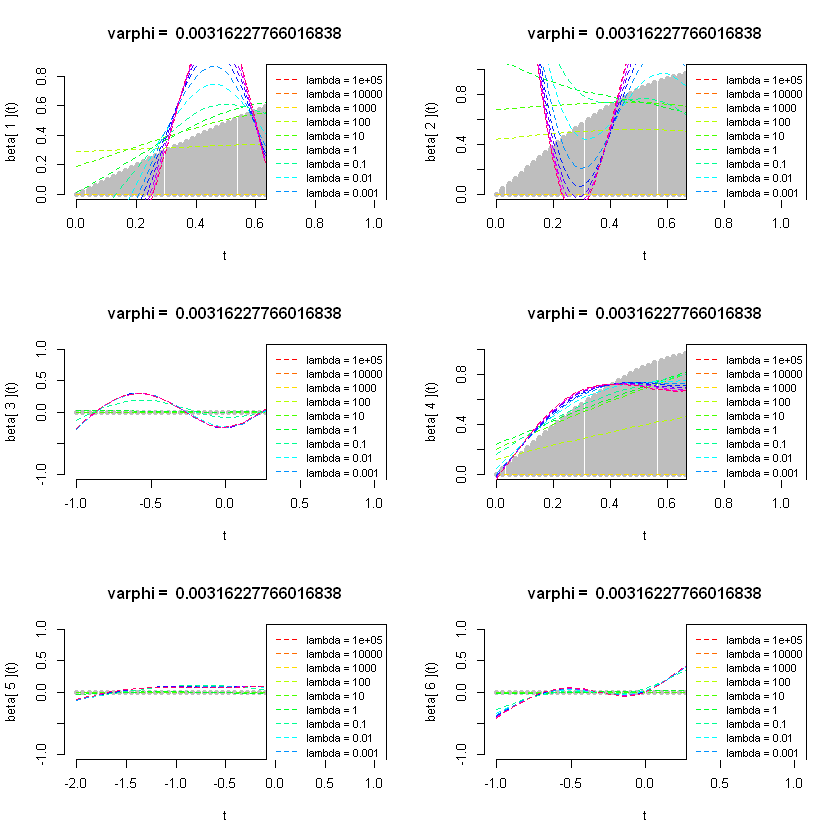

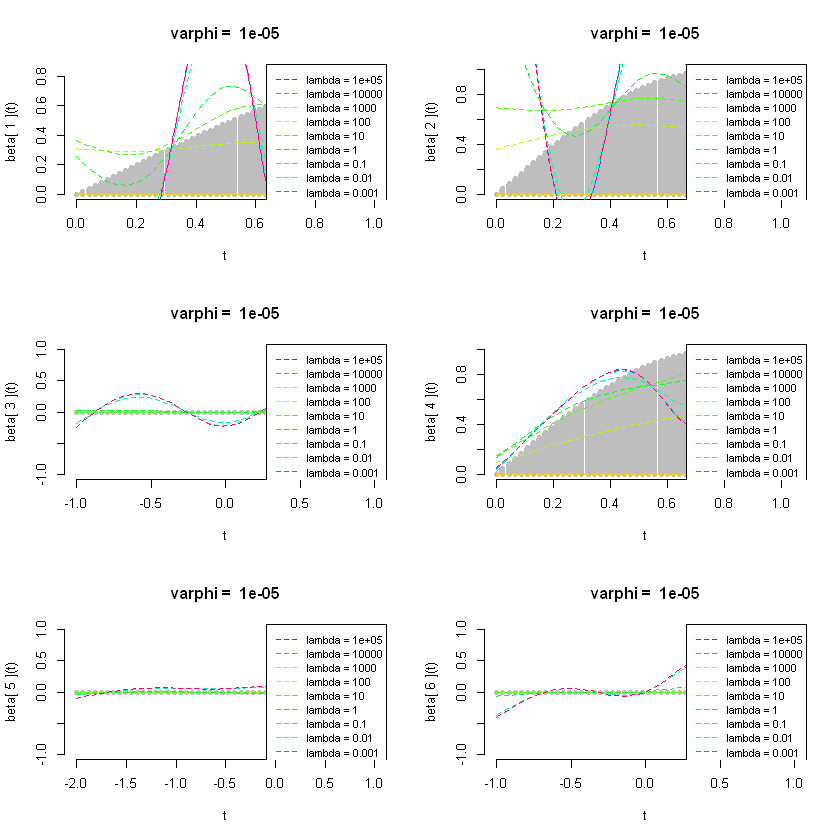

In [9]:

grpl <- list()
for (i in 1:length(phi)) {
  grpl[[i]] <- grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda, phi = phi[i], dfs = inputs$basis_functions )
}


# print all the output coefficients from the grpl
for (i in 1:length(phi)) {
      for(wl in 1:length(lambda)) {
        print(paste("phi:",phi[i],"lambda:",lambda[wl]))
        out = to_matrix_form(grpl[[i]]$Coef[[j]][,wl],predictors = predictors, basis_functions = inputs$basis_functions)
        print(out)

    }

}
colors <- rainbow(length(lambda))  # Generate a color palette with as many colors as there are lambda values

for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    y_values = beta_funcs[[j]](tps[[j]])
    plot(tps[[j]], y_values, type="h",col="gray",lwd=5,ylim=range(y_values),  xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    for(wl in 1:length(lambda)) {
      lines(tps[[j]], grpl[[i]]$Coef[[j]][,wl],lty=2, col=colors[wl])
    }
    legend("topright", legend=paste("lambda =", lambda), col=colors, lty=2, cex=0.8)

    title(paste("varphi = ", phi[i]))
  }
}

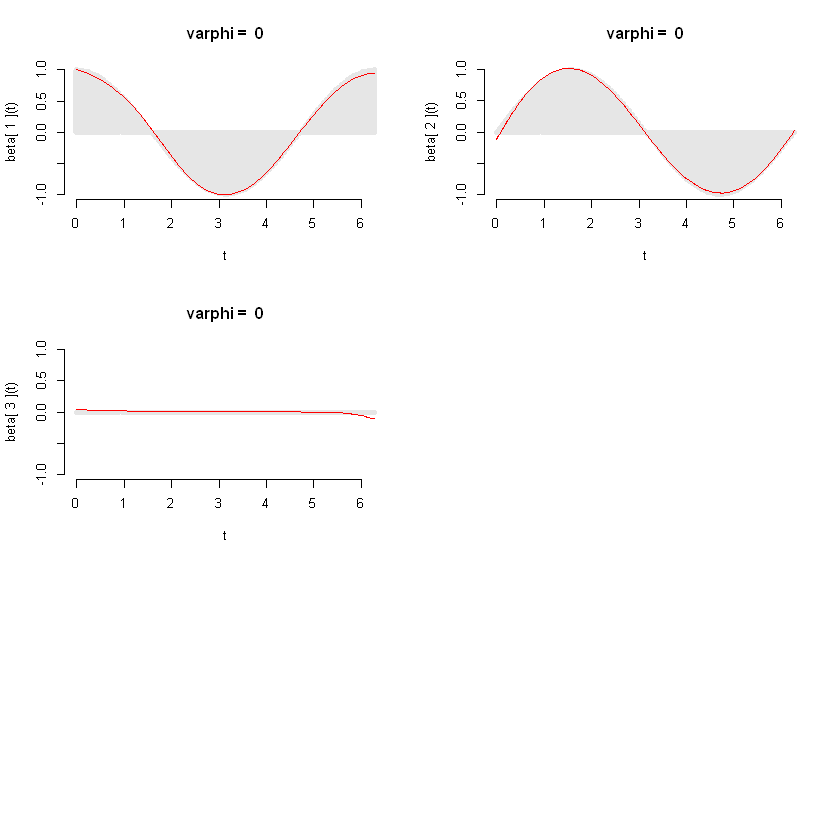

In [68]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    y_values = beta_funcs[[j]](tps[[j]])
    plot(tps[[j]], y_values, type="h",col=grey(0.9),lwd=5,ylim=range(y_values),  xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    for(wl in 1:length(lambda)) {
      lines(tps[[j]], grpl[[i]]$Coef[[j]][,wl],lty=wl, col="red")
    }
    title(paste("varphi = ", phi[i]))
  }
}

The best one is the:
- phi    = 100
- lambda = 1

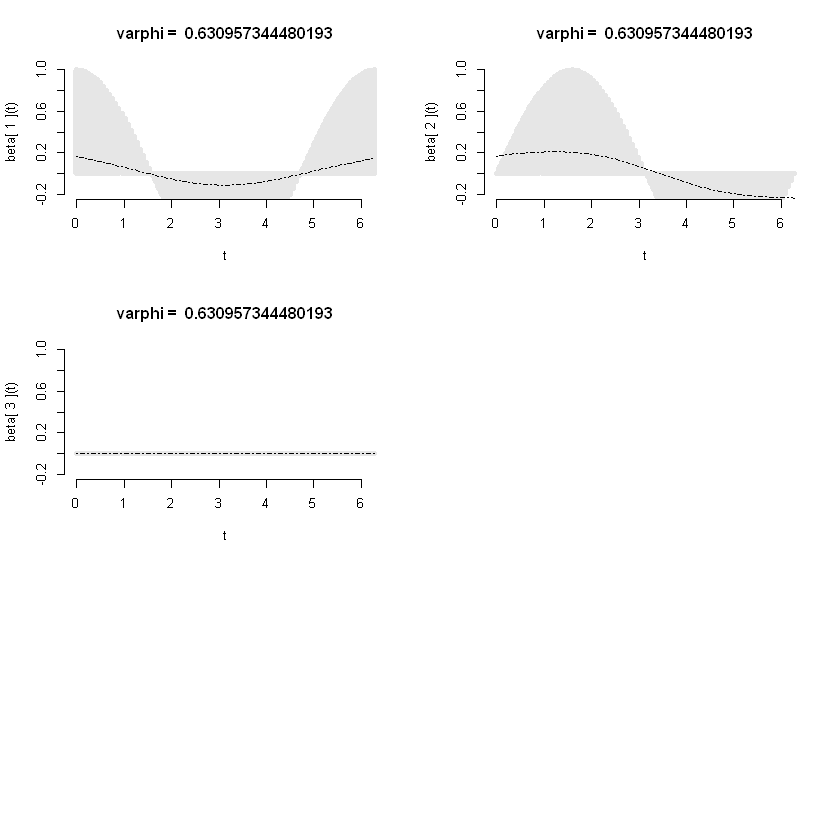

In [13]:
par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
for (j in 1:predictors) {
  plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),ylim=c(-0.2,1),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
  lines(tps[[j]], grpl[[5]]$Coef[[j]][,4],lty=4)
  title(paste("varphi = ", phi[5]))
}


In [14]:
# fit using functional smooth group lasso
lambda <- 10^seq(15,-90,by=-1)
phi <- 10^-1

grpl <- list()
for (i in 1:length(phi)) {
  grpl[[i]] <- grplFlinear(Y = Y, X = fobs, Tps = tps, lambda = lambda, phi = phi[i], dfs = 45)
}



Setting update.every = length(lambda) + 1
Lambda: 1e+15  nr.var: 1 
Lambda: 1e+14  nr.var: 1 
Lambda: 1e+13  nr.var: 1 
Lambda: 1e+12  nr.var: 1 
Lambda: 1e+11  nr.var: 1 
Lambda: 1e+10  nr.var: 1 
Lambda: 1e+09  nr.var: 1 
Lambda: 1e+08  nr.var: 1 
Lambda: 1e+07  nr.var: 1 
Lambda: 1e+06  nr.var: 1 
Lambda: 1e+05  nr.var: 1 
Lambda: 10000  nr.var: 1 
Lambda: 1000  nr.var: 1 
Lambda: 100  nr.var: 1 
Lambda: 10  nr.var: 91 
Lambda: 1  nr.var: 136 
Lambda: 0.1  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[18]"


Lambda: 0.01  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[19]"


Lambda: 0.001  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[20]"


Lambda: 1e-04  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[21]"


Lambda: 1e-05  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[22]"


Lambda: 1e-06  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[23]"


Lambda: 1e-07  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[24]"


Lambda: 1e-08  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[25]"


Lambda: 1e-09  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[26]"


Lambda: 1e-10  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[27]"


Lambda: 1e-11  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[28]"


Lambda: 1e-12  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[29]"


Lambda: 1e-13  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[30]"


Lambda: 1e-14  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[31]"


Lambda: 1e-15  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[32]"


Lambda: 1e-16  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[33]"


Lambda: 1e-17  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[34]"


Lambda: 1e-18  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[35]"


Lambda: 1e-19  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[36]"


Lambda: 1e-20  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[37]"


Lambda: 1e-21  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[38]"


Lambda: 1e-22  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[39]"


Lambda: 1e-23  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[40]"


Lambda: 1e-24  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[41]"


Lambda: 1e-25  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[42]"


Lambda: 1e-26  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[43]"


Lambda: 1e-27  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[44]"


Lambda: 1e-28  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[45]"


Lambda: 1e-29  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[46]"


Lambda: 1e-30  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[47]"


Lambda: 1e-31  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[48]"


Lambda: 1e-32  nr.var: 136 


Warning message in grplasso.default(x = Z, y = Y, index = index, model = LinReg(), :
"Maximal number of iterations reached for lambda[49]"


: 

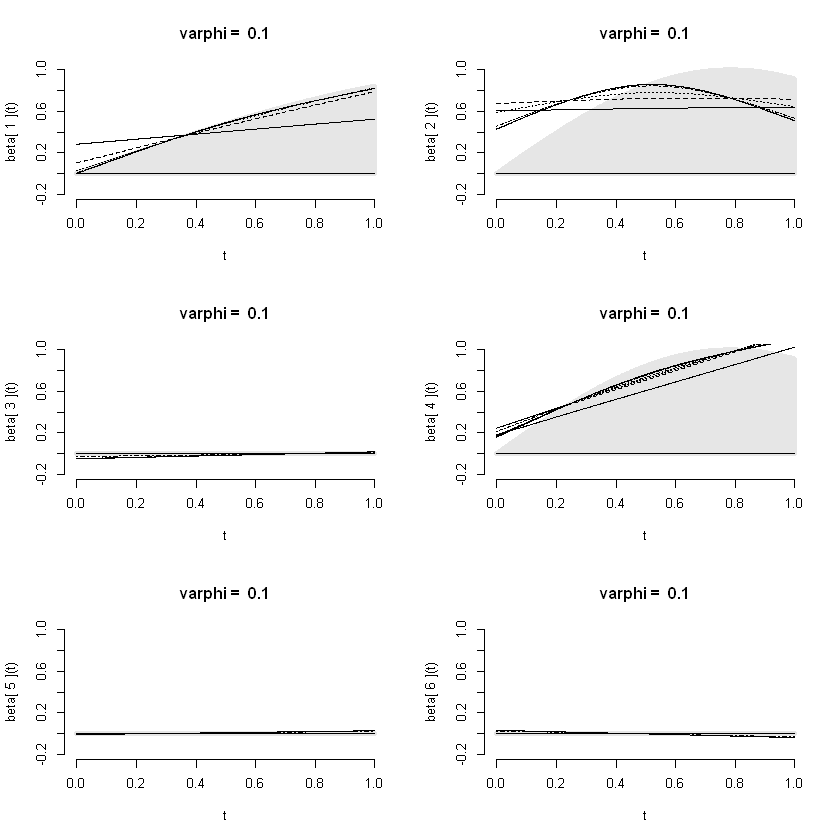

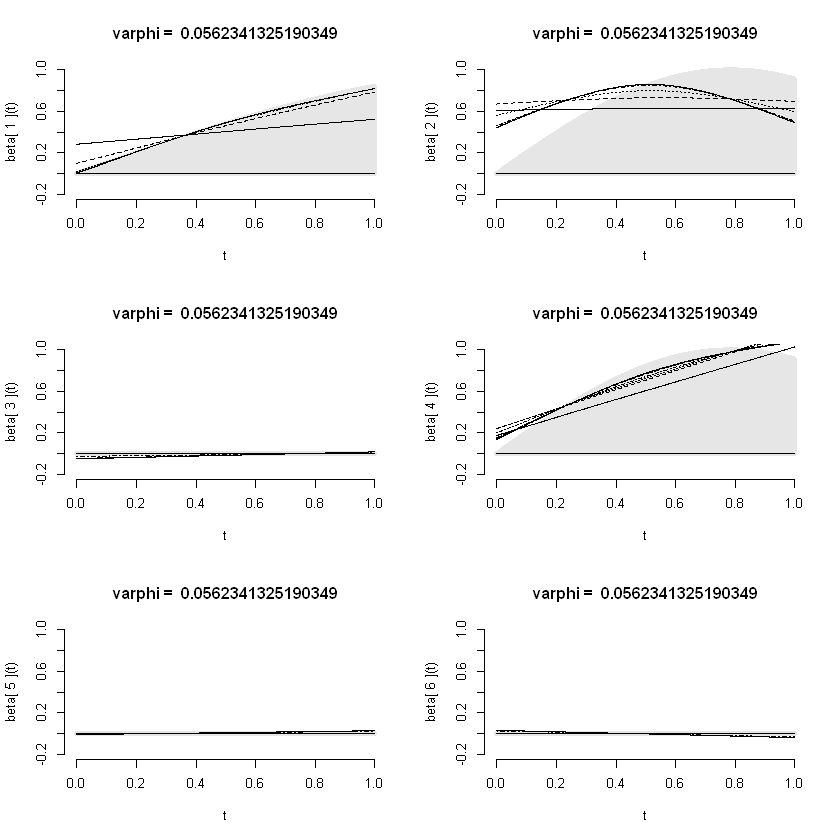

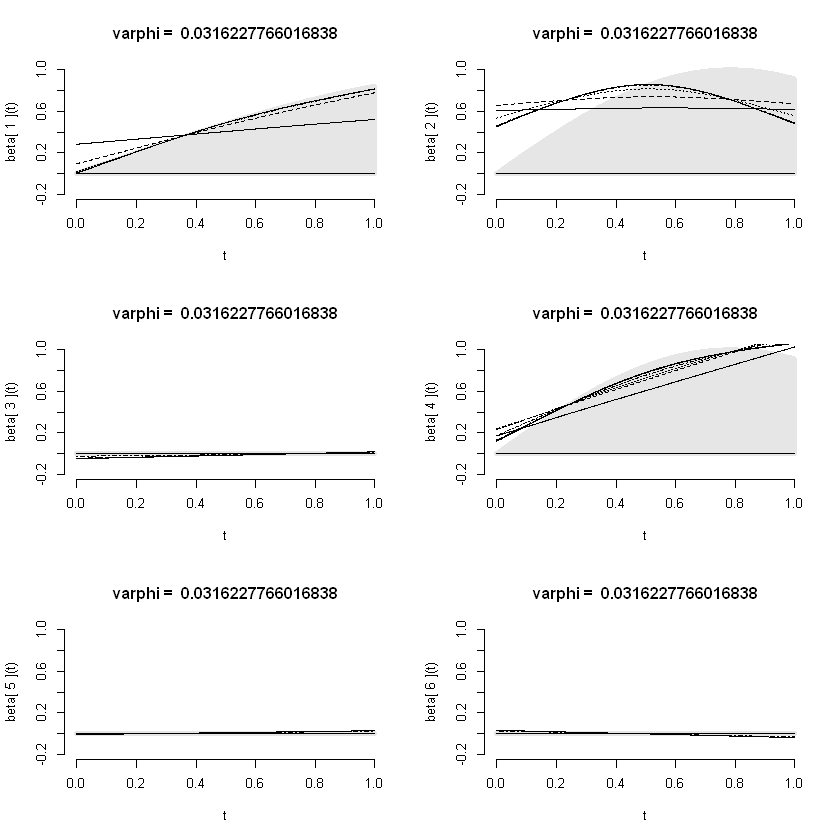

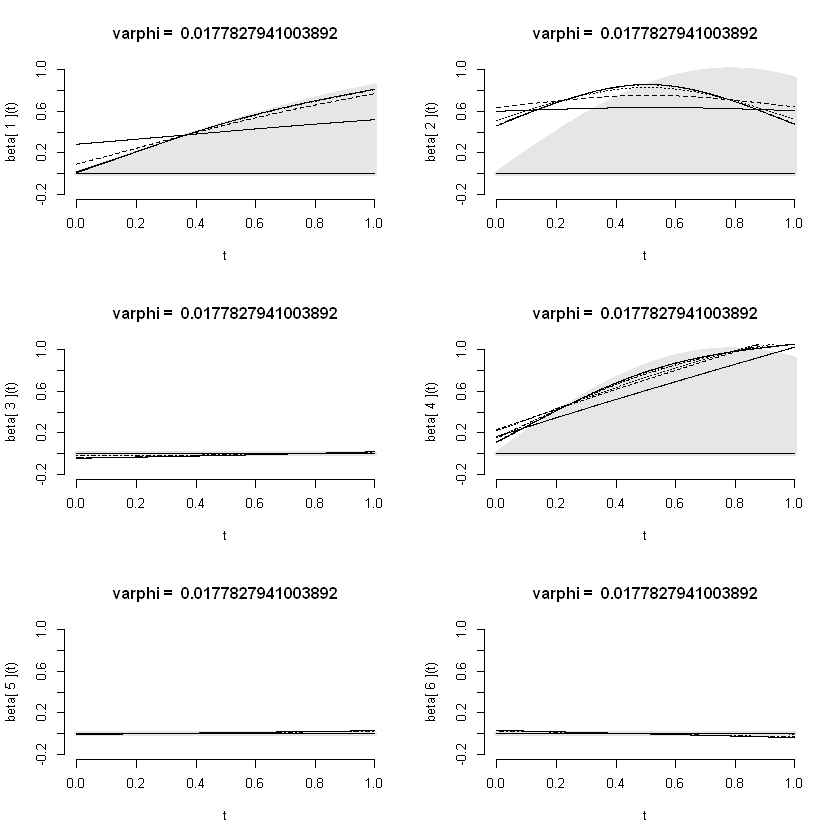

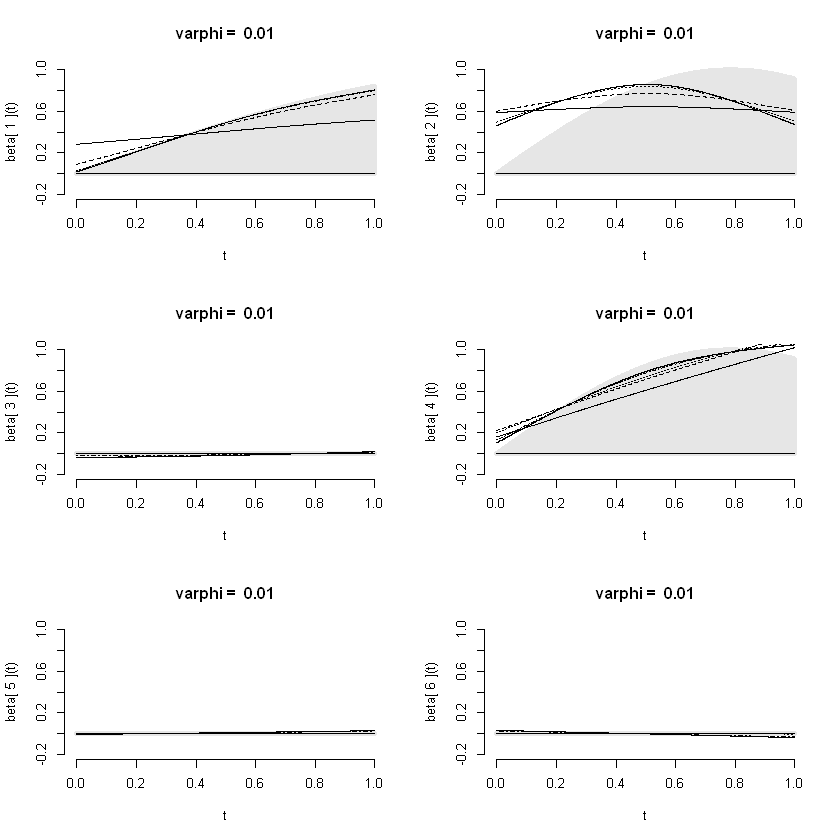

In [ ]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),ylim=c(-0.2,1),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    for(wl in 1:length(lambda)) {
      lines(tps[[j]], grpl[[i]]$Coef[[j]][,wl],lty=wl)
    }
    title(paste("varphi = ", phi[i]))
  }
}

In [ ]:
for (i in 1:length(phi)) {
  par(mfrow=c(3,2))  # Arrange the plots in a 3x2 grid
  for (j in 1:predictors) {
    plot(tps[[j]], beta_funcs[[j]](tps[[j]]), type="h",col=grey(0.9),ylim=c(-0.2,1),lwd=5, xlab="t", ylab=paste("beta[", j, "](t)"), bty="n")
    lines(tps[[j]], grpl[[i]]$Coef[[j]][,60],lty=60)
    title(paste("varphi = ", phi[i]))
  }
}

ERROR: Error in eval(expr, envir, enclos): oggetto 'phi' non trovato
